In [1]:
import torch
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorWithPadding

In [2]:
import datasets
datasets.__version__    

'2.14.4'

In [3]:
from datasets import load_dataset
raw_dataset = load_dataset("glue", "sst2", split="validation", cache_dir="datasets")
# raw_dataset = load_dataset("tasksource/subjectivity", split="test", cache_dir="datasets")
# raw_dataset = load_dataset("ag_news", split="test", cache_dir="datasets")


In [4]:
raw_dataset[0]

{'sentence': "it 's a charming and often affecting journey . ",
 'label': 1,
 'idx': 0}

In [7]:
# test0="/projects/tir5/users/sachink/embed-style-transfer/data/toxicity-jigsaw/test_0.jsonl"
# test1="/projects/tir5/users/sachink/embed-style-transfer/data/toxicity-jigsaw/test_1.jsonl"
# test="/projects/tir5/users/sachink/embed-style-transfer/data/toxicity-jigsaw/test.jsonl"

# import json
# with open(test, "w") as fout:
#     with open(test0) as f:
#         for line in f:
#             item = json.loads(line)
#             item['label'] = 0
#             fout.write(json.dumps(item)+"\n")
    
#     with open(test1) as f:
#         for line in f:
#             item = json.loads(line)
#             item['label'] = 1
#             fout.write(json.dumps(item)+"\n")

            


In [14]:
# from dataclasses import dataclass
# from transformers.tokenization_utils_base import PreTrainedTokenizerBase

# from typing import Any, Callable, Dict, List, NewType, Optional, Tuple, Union

# from transformers.utils import PaddingStrategy

# @dataclass
# class DataCollatorForGenerativeClassification:
#     """
#     Data collator that will dynamically pad the inputs received.

#     Args:
#         tokenizer ([`PreTrainedTokenizer`] or [`PreTrainedTokenizerFast`]):
#             The tokenizer used for encoding the data.
#         padding (`bool`, `str` or [`~utils.PaddingStrategy`], *optional*, defaults to `True`):
#             Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
#             among:

#             - `True` or `'longest'` (default): Pad to the longest sequence in the batch (or no padding if only a single
#               sequence is provided).
#             - `'max_length'`: Pad to a maximum length specified with the argument `max_length` or to the maximum
#               acceptable input length for the model if that argument is not provided.
#             - `False` or `'do_not_pad'`: No padding (i.e., can output a batch with sequences of different lengths).
#         max_length (`int`, *optional*):
#             Maximum length of the returned list and optionally padding length (see above).
#         pad_to_multiple_of (`int`, *optional*):
#             If set will pad the sequence to a multiple of the provided value.

#             This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
#             7.5 (Volta).
#         return_tensors (`str`):
#             The type of Tensor to return. Allowable values are "np", "pt" and "tf".
#     """

#     tokenizer: PreTrainedTokenizerBase
#     label_features = None
#     padding: Union[bool, str, PaddingStrategy] = True
#     max_length: Optional[int] = None
#     pad_to_multiple_of: Optional[int] = None
#     return_tensors: str = "pt"


#     def __call__(self, features):
#         new_features = {}
#         # for key in features:
#         #     if key not in ['input_ids', 'attention_mask']:
#         #         pass
        
#         batch = self.tokenizer.pad(
#             features,
#             padding=self.padding,
#             max_length=self.max_length,
#             pad_to_multiple_of=self.pad_to_multiple_of,
#             return_tensors=self.return_tensors,
#         )

#         if "label" in batch:
#             batch["labels"] = batch["label"]
#             del batch["label"]
#         if "label_ids" in batch:
#             batch["labels"] = batch["label_ids"]
#             del batch["label_ids"]
#         return batch

In [5]:
modelname = "gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(modelname)
tokenizer.bos_token

'<|endoftext|>'

In [6]:
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained(modelname)
# tokenizer = LlamaTokenizer.from_pretrained("/projects/tir6/general/sachink/personalized-LM/2023/llama/hf_model-7B")
# model_8bit = AutoModelForSeq2SeqLM.from_pretrained(modelname, device_map="auto", load_in_4bit=True)

[0.75458716 0.78211009 0.78440367 0.80275229 0.80504587 0.80275229
 0.80733945 0.80963303 0.8016055  0.80848624] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


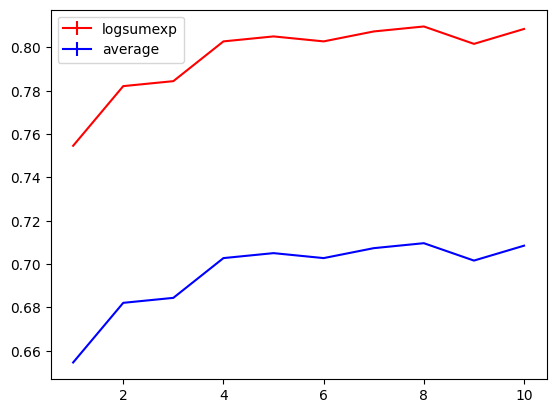

In [14]:
import json
import numpy as np
with open("results/main/glue-sst2/gpt2-results.txt") as f:
    y = []
    x = None
    c = 0
    for line in f:
        items = json.loads(line)
        if x is None:
            x = items['k']
        y.append(items['accuracy'])
    ymean = np.mean(y, axis=0)
    ystd = np.std(y, axis=0)
    print(ymean, ystd)

from matplotlib import pyplot as plt
plt.errorbar(x, ymean, ystd, color="red", label="logsumexp")
plt.errorbar(x, ymean-0.1, ystd, color="blue", label="average")
plt.legend(loc="best")

In [ ]:
from distutils.sysconfig import get_python_lib
print(get_python_lib())

/projects/tir1/users/sachink/data/anaconda3/envs/2022/lib/python3.9/site-packages


In [7]:

# tokenizer.pad_token = tokenizer.eos_token    
# tokenizer.pad_token_id = tokenizer.eos_token_id

def get_tokenized_dataset(raw_dataset, tokenizer, textfield="sentence", labelfield="label", label2id=None):
    def preprocess_function(examples):
        print(examples[textfield])
        x = tokenizer(["Review: \""+example+"\" Sentiment: " for example in examples[textfield]], max_length=200, truncation=True)
        if label2id is not None:
                x['label_ids'] = [label2id[label] for label in examples[labelfield]]
        return x

    tokenized_dataset = raw_dataset.map(preprocess_function, batched=True)
    columns_to_remove = raw_dataset.column_names
    if label2id is None:
        columns_to_remove.remove(labelfield)
    tokenized_dataset = tokenized_dataset.remove_columns(columns_to_remove)
    print(tokenized_dataset)
    tokenized_dataset.set_format("torch")

    return tokenized_dataset

# tokenized_dataset = get_tokenized_dataset(raw_dataset, "sentence", "label")
tokenized_dataset = get_tokenized_dataset(raw_dataset, tokenizer, "sentence", "label")
print("datasets and tokenizer loaded")

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

["it 's a charming and often affecting journey . ", 'unflinchingly bleak and desperate ', 'allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . ', "the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . ", "it 's slow -- very , very slow . ", 'although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women . ', 'a sometimes tedious film . ', "or doing last year 's taxes with your ex-wife . ", "you do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance . ", "in exactly 89 minutes , most of which passed as slowly as if i 'd been sitting naked on an igloo , formula 51 sank from quirky to jerky to utter turkey . ", 'the mesmerizing performances of the leads keep the film grounded and keep the audience riveted . ', 'it takes a strange kind of laziness to waste the talents of robert forster ,

In [8]:
model = AutoModelForCausalLM.from_pretrained(modelname, cache_dir="models/")    
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.half()
model.to(device)
model.eval()
print("model loaded")

model loaded


In [31]:
tokenizer(text_target="it's a charming and often affecting journey. ")
34,     3,    31,     7,     3,     9, 12216,    11,   557,     3,
        13403,  2027,     3,     5,     3,     1

{'input_ids': [34, 31, 7, 3, 9, 12216, 11, 557, 3, 13403, 2027, 5, 3, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [16]:
da

tensor([ 0.7535,  2.0354, -0.3524, -0.9173,  0.9565, -1.2065, -0.6502,  0.8415,
        -1.7567,  0.0036,  0.3490, -1.3118,  1.2644, -0.6531, -0.1681, -2.2571,
        -0.1078,  0.2644, -1.1279,  1.0084,  0.8168, -0.1889, -1.0064,  0.3960,
        -0.4331,  1.5127,  1.1862, -0.7253,  0.5306, -0.2234,  1.0244, -1.2056,
        -0.9442, -1.4338, -0.6599,  1.2370,  1.6559, -1.7489, -0.0348, -1.3525,
        -1.4152, -0.7757,  0.1930, -0.2399, -0.8766,  0.1931,  0.0812,  1.0250,
        -1.1279, -0.6901, -0.0976, -0.7248, -0.9342, -0.6082, -1.1890,  1.4084,
        -1.5045,  1.7472,  1.5501, -2.2234, -0.4696, -0.1120, -0.0973,  1.1490,
         1.6584, -0.3573,  0.6784,  1.6400,  0.3985, -0.3141, -0.9978, -1.0272,
         0.4755, -0.4340, -0.2300, -0.5429,  0.5253, -0.5102, -0.4684, -0.1358,
        -1.6379,  1.0335,  1.0438, -0.7773, -0.1023,  0.1375, -1.8584,  1.3634,
         2.1525, -0.1336, -0.1900,  0.0870, -0.3544,  2.7223, -0.5800, -1.3595,
         0.9350, -0.2262, -1.5050, -1.03

In [ ]:
model = model.to_bettertransformer()

In [ ]:
alllabelstrings = [
    [  
        "This review exhibits a negative bias. ",
        "The inclination of this review is towards the negative side. ",
        "There is a unfavorable slant in this review. ",
        "The overall tone of this review is negative. ",
        "This review shows a leaning against the subject. ",
        "There is a negative inclination in this review. ",
        "The overall impression of this review is pessimistic. ",
        "This review tends to disfavor the subject being discussed. ",
        "There is a negative inclination evident in this review. ",
        "The general sentiment of this review is negative. ",
    ],
    [
        "This review exhibits a positive bias. ",
        "The inclination of this review is towards the positive side. ",
        "There is a favorable slant in this review. ",
        "The overall tone of this review is positive. ",
        "This review shows a leaning in favor of the subject. ",
        "There is a positive inclination in this review. ",
        "The overall impression of this review is optimistic. ",
        "This review tends to favor the subject being discussed. ",
        "There is a positive inclination evident in this review. ",
        "The general sentiment of this review is positive. ",
    ]
]

In [ ]:
# tokenizer.pad_token = tokenizer.eos_token    
# tokenizer.pad_token_id = tokenizer.eos_token_id

num_labels = len(alllabelstrings)
num_labelstrings = len(alllabelstrings[0])

alllabelstrings_tokenized = []
for labelstrings in alllabelstrings:
    labelstrings_tokenized = []
    for labelstring in labelstrings:
        labelstrings_tokenized.append(tokenizer(labelstring, add_special_tokens=False, padding=False, return_tensors="pt").to(device))
    alllabelstrings_tokenized.append(labelstrings_tokenized)


# alllabelstrings_tokenized


In [ ]:
def process_batch(batch, alllabelstrings_tokenized, i, j):
    labelstring_tokenized = alllabelstrings_tokenized[i][j]
    #print(batch.keys())
    batch = {k: v.to(device) for k, v in batch.items()}
    batch_size, seq_len = batch['input_ids'].size()
    label_len = labelstring_tokenized['input_ids'].size(-1)
    # print(batch_size, seq_len, label_len)
    
    expanded_batch_input_ids = batch['input_ids'].repeat_interleave(labelstring_tokenized['input_ids'].size(0), dim=0) # output size = (#labels*batch_size, L)
    expanded_label_input_ids = labelstring_tokenized['input_ids'].view(1, -1, label_len).expand(batch_size, -1, -1).contiguous().view(-1, label_len)
    input_ids = torch.cat([expanded_label_input_ids, expanded_batch_input_ids], dim=1)

    expanded_batch_attention_mask = batch['attention_mask'].repeat_interleave(labelstring_tokenized['attention_mask'].size(0), dim=0) # output size = (#labels*batch_size, L)
    expanded_label_attention_mask = labelstring_tokenized['attention_mask'].view(1, -1, label_len).expand(batch_size, -1, -1).contiguous().view(-1, label_len)
    attention_mask = torch.cat([expanded_label_attention_mask, expanded_batch_attention_mask], dim=1)
    
    label_mask = torch.ones_like(attention_mask)
    label_mask[:, :label_len] = 0
    labels = batch['labels']
    batch['input_ids'] = input_ids
    batch['attention_mask'] = attention_mask
    bsz = input_ids.size(0)
    batch.pop("labels", None)
    batch.pop('idx', None)

    return batch, label_mask

In [ ]:
def process_batch2(batch, alllabelstrings_tokenized, i):
    merged_labelstrings = alllabelstrings_tokenized[i]
    # print(merged_labelstrings)
    batch = {k: v.to(device) for k, v in batch.items()}
    batch_size, seq_len = batch['input_ids'].size()
    label_len = merged_labelstrings['input_ids'].size(-1)
    # print(batch_size, seq_len, label_len)
    
    expanded_batch_input_ids = batch['input_ids'].repeat_interleave(merged_labelstrings['input_ids'].size(0), dim=0) # output size = (#labels*batch_size, L)
    expanded_label_input_ids = merged_labelstrings['input_ids'].view(1, -1, label_len).expand(batch_size, -1, -1).contiguous().view(-1, label_len)
    input_ids = torch.cat([expanded_label_input_ids, expanded_batch_input_ids], dim=1)

    expanded_batch_attention_mask = batch['attention_mask'].repeat_interleave(merged_labelstrings['attention_mask'].size(0), dim=0) # output size = (#labels*batch_size, L)
    expanded_label_attention_mask = merged_labelstrings['attention_mask'].view(1, -1, label_len).expand(batch_size, -1, -1).contiguous().view(-1, label_len)
    attention_mask = torch.cat([expanded_label_attention_mask, expanded_batch_attention_mask], dim=1)
     
    # labels = batch['labels']
    batch['input_ids'] = input_ids
    batch['attention_mask'] = attention_mask
    bsz = input_ids.size(0)
    batch.pop("labels", None)
    batch.pop('idx', None)

    return batch, None

In [ ]:
def merge_batches(batches, label_masks):
    maxlen = max([batch['input_ids'].size(-1) for batch in batches])
    batchsize = batches[0]['input_ids'].size(0)
    # print(batchsize, maxlen)
    padmax = torch.empty(batchsize, maxlen).long().data.fill_(tokenizer.pad_token_id).to(device)
    maskmax = torch.ones_like(padmax).int().to(device)
    # print(padmax)
    # print(maskmax)
    for ij in range(len(batches)):
        extralen = maxlen - batches[ij]['input_ids'].size(-1)
        # batches[ij] = tokenizer.pad(batches[ij], max_length=maxlen, return_attention_mask=True, return_tensors="pt")
        batches[ij]['input_ids'] = torch.cat([batches[ij]['input_ids'], padmax[:, :extralen]], dim=-1)
        batches[ij]['attention_mask'] = torch.cat([batches[ij]['attention_mask'], 1-maskmax[:, :extralen]], dim=-1)
        label_masks[ij] = torch.cat([label_masks[ij], maskmax[:, :extralen]], dim=-1)
        
    batch = {'input_ids': torch.cat([batch['input_ids'] for batch in batches], dim=0), 'attention_mask': torch.cat([batch['attention_mask'] for batch in batches], dim=0)}
    label_mask = torch.cat(label_masks, dim=0)
    # print(batch['input_ids'].size())
    # print(batch['attention_mask'].size())
    # print(label_mask.size())
    # input()

    return batch, label_mask

In [ ]:
from torch.utils.data import DataLoader

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")
data_collator.tokenizer.pad_token_id = tokenizer.eos_token_id
eval_dataloader = DataLoader(tokenized_dataset, collate_fn=data_collator, batch_size=4)

# print(tokenized_dataset['validation'])
# batch = next(iter(eval_dataloader))
# batch

In [ ]:
from tqdm import tqdm
import numpy as np
accurate = 0
total = 0
all_predictions = []
all_labels = []
############################################
with torch.no_grad():
    for batch in tqdm(eval_dataloader):
    # if True:
        nlls = []
        subbatches = []
        label_masks = []
        for i in range(len(alllabelstrings_tokenized)):
            for j in range(len(alllabelstrings_tokenized[i])):
                sub_batch, label_mask = process_batch(batch, alllabelstrings_tokenized, i, j)
                subbatches.append(sub_batch)
                label_masks.append(label_mask)

        new_batch, label_mask = merge_batches(subbatches, label_masks)
        outputs = model(**new_batch)
        logits1 = outputs.logits
        
        shift_logprobs = torch.nn.functional.log_softmax(logits1[..., :-1, :], dim=-1).contiguous()
        shift_target = new_batch['input_ids'][..., 1:].contiguous()

        nll = torch.nn.functional.nll_loss(shift_logprobs.view(-1, shift_logprobs.size(-1)), shift_target.view(-1), reduction="none", ignore_index=tokenizer.pad_token_id).view(-1, shift_target.size(-1))
        nll = nll * label_mask[..., 1:]

        deno = (shift_target.ne(tokenizer.pad_token_id).float() * label_mask[..., 1:]).sum(dim=-1)

        nll = nll.sum(dim=-1)/deno
        nll = nll.view(num_labels, num_labelstrings, -1)

        nll = -torch.logsumexp(-nll, dim=1) + np.log(num_labelstrings)
        nll = nll.min(dim=0)

        accurate += nll[1].eq(batch['labels'].cuda()).int().sum().item()
        total += nll[1].size(0)
        all_predictions += nll[1].tolist()
        all_labels += batch['labels'].tolist()
        # print(all_predictions)
        # print(all_labels)
        # print(accurate, "/", nll[1].size(0))

        del new_batch
        del subbatches
        del label_masks


100%|██████████| 9500/9500 [49:36<00:00,  3.19it/s]


In [ ]:
print(f"Accuracy: {accurate}/{total} or {accurate/total}")

Accuracy: 32977/38000 or 0.8678157894736842


In [ ]:
# SST-2: 747/872, 0.856651376146789
# SST-2: 756/872, 0.8669724770642202
# Yelp Polarity: 31487/38000, 0.8286052631578947
# Accuracy: 32977/38000 or 0.8678157894736842
# # alllabelstrings = [
# #     [  
# #         "This review exhibits a negative bias.",
# #         "The inclination of this review is towards the negative side.",
# #         "There is a unfavorable slant in this review.",
# #         "The overall tone of this review is negative.",
# #         "This review shows a leaning against the subject.",
# #         "There is a negative inclination in this review.",
# #         "The overall impression of this review is pessimistic.",
# #         "This review tends to disfavor the subject being discussed.",
# #         "There is a negative inclination evident in this review.",
# #         "The general sentiment of this review is negative.",
# #     ],
# #     [
# #         "This review exhibits a positive bias.",
# #         "The inclination of this review is towards the positive side.",
# #         "There is a favorable slant in this review.",
# #         "The overall tone of this review is positive.",
# #         "This review shows a leaning in favor of the subject.",
# #         "There is a positive inclination in this review.",
# #         "The overall impression of this review is optimistic.",
# #         "This review tends to favor the subject being discussed.",
# #         "There is a positive inclination evident in this review.",
# #         "The general sentiment of this review is positive.",
# #     ]
# # ]

# # alllabelstrings = [["This review is leaning negative. "], ["This review is leaning positive. "]]
# # alllabelstrings = [["This review criticizes. "], ["This review appreciates. "]]

# alllabelstrings = [
#     [  
#         "This review exhibits a negative intent.",
#         #"The inclination of this review is towards the negative side.",
#         #"There is a unfavorable slant in this review.",
#         # "The overall tone of this review is negative.",
#         # "This review shows a leaning against the subject.",
#         "There is a negative inclination in this review.",
#         # "The overall impression of this review is pessimistic.",
#         # "This review tends to disfavor the subject being discussed.",
#         # "There is a negative inclination evident in this review.",
#         # "The general sentiment of this review is negative.",
#     ],
#     [
#         "This review exhibits a positive intent.",
#         #"The inclination of this review is towards the positive side.",
#         #"There is a favorable slant in this review.",
#         # "The overall tone of this review is positive.",
#         # "This review shows a leaning in favor of the subject.",
#         "There is a positive inclination in this review.",
#         # "The overall impression of this review is optimistic.",
#         # "This review tends to favor the subject being discussed.",
#         # "There is a positive inclination evident in this review.",
#         # "The general sentiment of this review is positive.",
#     ]
# ]

# num_labels = len(alllabelstrings)
# num_labelstrings = [len(labelstrings) for labelstrings in alllabelstrings]

# merged_labelstrings = []
# for labelstrings in alllabelstrings:
#     merged_labelstrings += labelstrings

# tokenizer.padding_side = "left"
# merged_labelstrings_tokenized = tokenizer(merged_labelstrings, add_special_tokens=False, padding=True, return_tensors="pt").to(device)
# tokenizer.padding_side = "right"

# print(len(merged_labelstrings))
# print(merged_labelstrings_tokenized['input_ids'].size())
# for key in merged_labelstrings_tokenized:
#     merged_labelstrings_tokenized[key] = merged_labelstrings_tokenized[key].view(num_labels, num_labelstrings[0], -1)

# tokenizer.pad_token = tokenizer.eos_token    
# tokenizer.pad_token_id = tokenizer.eos_token_id


In [ ]:
from seaborn import 